In [5]:
import torch
import numpy as np
import os
import json
import sys
from tqdm import tqdm

sys.path.append("..")
from src.image_data import get_quantized_cifar10_loaders
from src.image_models import MyrtleNet, ResNet

### Compute Variances

In [2]:
def compute_variance(model, mean_loader, variance_loader, sims, device="cpu"):

    # compute mean using accumulation
    m = 20
    for i, (x, y) in enumerate(mean_loader):
        if i >= m:
            break
        loss, logits = model(x.to(device), y.to(device))
        loss /= m
        loss.backward()
    mean = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            mean[name] = param.grad

    
    iter_num = 0
    variance = 0
    while iter_num < sims:
        for x, y in variance_loader:
            if iter_num >= sims:
                break

            model.zero_grad()
            loss, logits = model(x.to(device), y.to(device))
            loss.backward()
            for name, param in model.named_parameters():
                if param.requires_grad:
                    variance += torch.norm(param.grad - mean[name]) ** 2 / sims

            iter_num += 1
    return variance.detach().cpu().item()

def compute_variance_curve(batch_size, seed=0, sims=50, device="cuda:3", augment=True):
    if augment:
        out_dir = f"/mnt/ssd/ronak/output/variance/batch_size_{batch_size}/{seed}/"
        log_dir = f"/home/ronak/resnets/logs/variance/batch_size_{batch_size}/{seed}/"
    else:
        out_dir = f"/mnt/ssd/ronak/output/variance/b{batch_size}/{seed}/"
        log_dir = f"/home/ronak/resnets/logs/variance/b{batch_size}/{seed}/"
    steps = torch.arange(100, 3100, 100)

    with open(os.path.join(log_dir, "config.json"), "r") as infile:
        config = json.load(infile)
    model_cfg = config['model_cfg']

    mean_loader, _ = get_quantized_cifar10_loaders(1024, 0)
    variance_loader, _ = get_quantized_cifar10_loaders(batch_size, 0)

    
    
    variances = []
    observed_steps = []
    for step in tqdm(steps):
        fname = os.path.join(out_dir, f"ckpt_{step}.pt")
        if os.path.exists(fname):
            model = MyrtleNet(**model_cfg)
            model.load_state_dict(torch.load(fname))
            model.to(device)
            model.eval()
            observed_steps.append(step.item())
            variances.append(compute_variance(model, mean_loader, variance_loader, sims, device=device))
    
    if augment:
        np.save(f"output/batch_size_{batch_size}_steps.npy", np.array(observed_steps))
        np.save(f"output/batch_size_{batch_size}_variances.npy", np.array(variances))
    else:
        np.save(f"output/b{batch_size}_steps.npy", np.array(observed_steps))
        np.save(f"output/b{batch_size}_variances.npy", np.array(variances))

### Plot Variance and Loss Curves

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams["axes.labelsize"] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.titlesize'] = 16
# mpl.rcParams['text.usetex'] = True

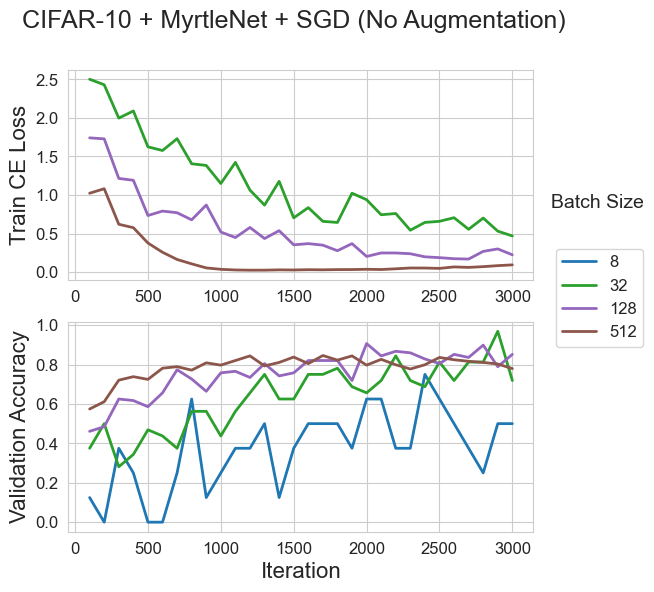

In [8]:
sns.set_style("whitegrid")

augment = False

fig, ax = plt.subplots(2, 1, figsize=(6, 6))

steps = torch.arange(100, 3100, 100)
seeds = [0]

colors = ["tab:blue", "tab:green", "tab:purple", "tab:brown", "tab:red", "black", "orange"]

start = 0

for i, batch_size in enumerate([8, 32, 128, 512]):
    avg_train_loss = np.zeros((len(steps)))
    avg_validation_accuracy = np.zeros((len(steps)))

    for seed in seeds:
        if augment:
            log_dir = f"/home/ronak/resnets/logs/variance/batch_size_{batch_size}/{seed}/"
        else:
            log_dir = f"/home/ronak/resnets/logs/variance/b{batch_size}/{seed}/"
        train_loss = []
        validation_accuracy = []
        for step in steps:
            with open(os.path.join(log_dir, f"step_{step}.json"), "r") as infile:
                stats = json.load(infile)
            train_loss.append(stats['train_loss'])
            validation_accuracy.append(stats['validation_accuracy'])

        if batch_size != 8:
            ax[0].plot(steps[start:], train_loss[start:], linewidth=1, alpha=0.3, color=colors[i])
        ax[1].plot(steps[start:], validation_accuracy[start:], linewidth=1, alpha=0.3, color=colors[i])

        avg_train_loss += np.array(train_loss)
        avg_validation_accuracy += np.array(validation_accuracy)

    avg_train_loss = avg_train_loss / len(seeds)
    avg_validation_accuracy = avg_validation_accuracy / len(seeds)
    if batch_size != 8:
        ax[0].plot(steps[start:], avg_train_loss[start:], linewidth=2, color=colors[i])
    ax[1].plot(steps[start:], avg_validation_accuracy[start:], linewidth=2, color=colors[i], label=str(batch_size))

# for i, batch_size in enumerate([8192, 32768]):
#     seed = 0
#     log_dir = f"/home/ronak/resnets/logs/variance/batch_size_{batch_size}/{seed}/"
#     train_loss = []
#     validation_accuracy = []
#     for step in steps:
#         with open(os.path.join(log_dir, f"step_{step}.json"), "r") as infile:
#             stats = json.load(infile)
#         train_loss.append(stats['train_loss'])
#         validation_accuracy.append(stats['validation_accuracy'])

#     ax[0].plot(steps[start:], train_loss[start:], linewidth=2, color=colors[i + 5])
#     ax[1].plot(steps[start:], validation_accuracy[start:], linewidth=2, color=colors[i + 5], label=str(batch_size))

ax[1].set_xlabel("Iteration")
ax[0].set_ylabel("Train CE Loss")
ax[1].set_ylabel("Validation Accuracy")
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(1.01, 0.5), ncol=1)

fig.text(0.93, 0.65, "Batch Size", fontsize=14)

if augment:
    fig.suptitle("CIFAR-10 + MyrtleNet + SGD", fontsize=18)
else:
    fig.suptitle("CIFAR-10 + MyrtleNet + SGD (No Augmentation)", fontsize=18)

In [10]:
# sns.set_style("whitegrid")

# fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# seeds = [0]
# augment = False

# for batch_size in [8, 32, 128, 512, 2048]:

#     if augment:
#         observed_steps = np.load(f"output/batch_size_{batch_size}_steps_.npy")
#         variances = np.load(f"output/batch_size_{batch_size}_variances.npy")
#     else:
#         observed_steps = np.load(f"output/b{batch_size}_steps.npy")
#         variances = np.load(f"output/b{batch_size}_variances.npy")

#     ax.plot(observed_steps, np.log10(variances), label=str(batch_size))

# ax.set_xlabel("Iteration")
# ax.set_ylabel("Variance of Gradient Estimate")
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(1.01, 0.5), ncol=1)

# fig.text(0.93, 0.65, "Batch Size", fontsize=14)

# if augment:
#     fig.suptitle("CIFAR-10 + MyrtleNet + SGD", fontsize=18)
# else:
#     fig.suptitle("CIFAR-10 + MyrtleNet + SGD (No Augmentation)", fontsize=18)

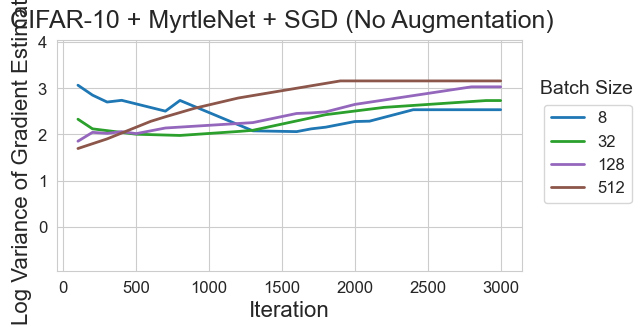

In [16]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
seeds = [0]
steps = np.arange(100, 3100, 100)
augment = False

colors = ["tab:blue", "tab:green", "tab:purple", "tab:brown", "tab:red", "black", "orange"]

for i, batch_size in enumerate([8, 32, 128, 512]):

    avg_var = np.zeros((len(steps)))

    for seed in seeds:
        if augment:
            observed_steps = np.load(f"output/batch_size_{batch_size}_steps_seed_{seed}.npy")
            variances = np.load(f"output/batch_size_{batch_size}_variances_seed_{seed}.npy")
        else:
            observed_steps = np.load(f"output/b{batch_size}_steps_seed_{seed}.npy")
            variances = np.load(f"output/b{batch_size}_variances_seed_{seed}.npy")

        ax.plot(observed_steps, np.log10(variances), alpha=0.3, linewidth=1.0, color=colors[i])

        avg_var += np.interp(steps, observed_steps, np.log10(variances))

    ax.plot(steps, avg_var / len(seeds), linewidth=2.0, label=str(batch_size), color=colors[i])

ax.set_xlabel("Iteration")
ax.set_ylabel("Log Variance of Gradient Estimate")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(1.01, 0.5), ncol=1)

fig.text(0.93, 0.7, "Batch Size", fontsize=14)

ax.set_ylim((-0.95, 4.05))

if augment:
    fig.suptitle("CIFAR-10 + MyrtleNet + SGD", fontsize=18)
else:
    fig.suptitle("CIFAR-10 + MyrtleNet + SGD (No Augmentation)", fontsize=18)